# Inhibitor Diffusion and Germination - Three dimensions

## Numerical experiments - Week 47/2024

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda, float32
import plotly.graph_objects as go

## 1. General assumptions

The spore is now situated in a three-dimensional volume, being able to diffuse in more directions.

The assumptions on permeation through the cell wall and in the medium are as in the previous experiment, but the PDE solutions now extend to three dimensions and all sides of the spore are subject to inhibitor flux.

## 2. Algorithmic framework

### 2.1. Analytical formula

First, a function for obtaining the analytical solution is defined as in the previous experiment.

In [2]:
def permeation_time_dependent_analytical_alt(c_in, c_out, t, Ps, A, V, alpha=1.0):
    """
    Compute the concentration of a solute in a spore given the initial and external concentrations.
    inputs:
        c_in (float) - the initial concentration of the solute;
        c_out (float) - the external concentration of the solute;
        t (float) - time;
        Ps (float) - the spore membrane permeation constant;
        A (float) - the surface area of the spore;
        V (float) - the volume of the spore;
        alpha (float) - permeable fraction of the area; defaults to 1.
    """
    tau = V / (alpha * A * Ps)
    c = c_out - (c_out - c_in) * np.exp(-t / tau)
    return c

def permeation_time_dependent_analytical(c_in, c_out, t, Dm, A, V):
    """
    Compute the concentration of a solute in a spore given the initial and external concentrations.
    inputs:
        c_in (float) - the initial concentratio the solute;
        c_out (float) - the external concentration of the solute;
        t (float) - time;
        Dm (float) - diffusion coefficient of the solute through the membrane;
        A (float) - the surface area of the spore;
        V (float) - the volume of the spore.
    """
    tau = V / (A * Dm)
    c = c_out - (c_out - c_in) * np.exp(-t / tau)
    return c

def diffusion_time_dependent_analytical_src(c_init, D, time, vol):
    """
    Compute the analytical solution of the time-dependent diffusion equation at the source.
    inputs:
        c_init (float) - the initial concentration;
        D (float) - the diffusion constant;
        time (float) - the time at which the concentration is to be computed;
        vol (float) - the volume of the initial concentration cell.
    """
    return vol * c_init / np.power(4*np.pi*D*time, 1.5)

With it, it can be quickly compared how the number of dimensions affects the concentraiton change

In [3]:
Ps = 1.9e-6
Dm = 1.9e-5
t_max = 14400 # 4 hours
times = np.linspace(0, t_max, 1000)
# alpha = 10.0
spore_wall_vol = 125

# 2D setup
spore_area = 20 # 4 edges of square
# c_analytical_2D = permeation_time_dependent_analytical(1, 0, times, Ps, spore_area, spore_wall_vol, alpha)
c_analytical_2D = permeation_time_dependent_analytical(1, 0, times, Dm, spore_area, spore_wall_vol)

# 3D setup
spore_area = 150
# c_analytical_3D = permeation_time_dependent_analytical(1, 0, times, Ps, spore_area, spore_wall_vol, alpha)
c_analytical_3D = permeation_time_dependent_analytical(1, 0, times, Dm, spore_area, spore_wall_vol)

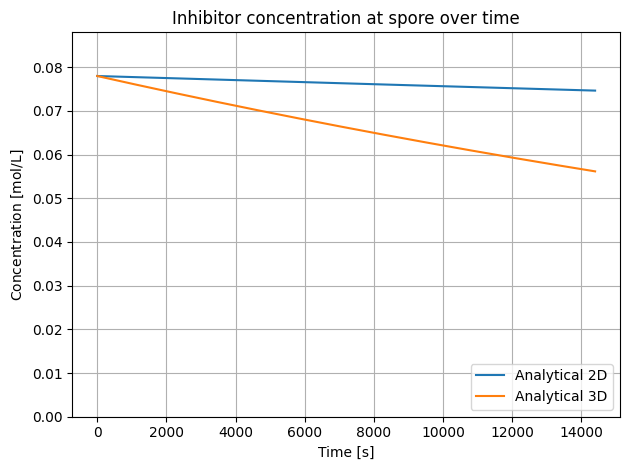

In [86]:
c_scale = 0.078
c_analytical_2D_scaled = c_scale * c_analytical_2D
c_analytical_3D_scaled = c_scale * c_analytical_3D

# Plot the concentration evolution
fig, ax = plt.subplots()
ax.plot(times, c_analytical_2D_scaled, label='Analytical 2D')
ax.plot(times, c_analytical_3D_scaled, label='Analytical 3D')
ax.set_ylim(0, c_scale+0.01)
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Concentration $[\text{mol}/\text{L}]$')
ax.set_title('Inhibitor concentration at spore over time')
ax.legend(loc='lower right')
ax.grid()
fig.tight_layout()

Additionally, the analytical solution can be rewritten to find the permeation constant needed to reach a specific final concentration, starting from $c_0$, at a given time $t'$:

$$
\Delta c(0)e^{-t/\tau}=c_{\textrm{out}} -c_{\textrm{in}}(t')
$$

$$
e^{-t/\tau}=\frac{c_{\textrm{out}} -c_{\textrm{in}}(t')}{\Delta c(0)}
$$

$$
\frac{t}{\tau}=-\ln{\frac{c_{\textrm{out}} -c_{\textrm{in}}(t')}{\Delta c(0)}}
$$

$$
\frac{tKAP_s}{V_{\textrm{cw}}}=-\ln{\frac{c_{\textrm{out}} -c_{\textrm{in}}(t')}{\Delta c(0)}}
$$

$$
P_s=-\frac{V_{\textrm{cw}}}{tKA}\ln{\frac{c_{\textrm{out}} -c_{\textrm{in}}(t')}{\Delta c(0)}}
$$

Given solid assumptions about the rest of the parameters, this can provide better insight about the material properties of the permeating cell wall.

In [3]:
def compute_permeation_constant(c_in, c_out, c_0, t, A, V, alpha=1.0):
    """
    Compute the permeation constant P_s given the constant external concentration,
    the initial concentration of the solute, the concentration of the solute at time t
    and the surface area and volume of the spore.
    inputs:
        c_in (float) - the initial concentration of the solute;
        c_out (float) - the external concentration of the solute;
        c_0 (float) - the concentration of the solute at time t;
        t (float) - time;
        A (float) - the surface area of the spore;
        V (float) - the volume of the spore;
        alpha (float) - permeable fraction of the area; defaults to 1.
    """
    Ps = V / (alpha * A * t) * np.log((c_out - c_0) / (c_out - c_in))
    return Ps

### 2.2. Numerical algorithm

To test this against finite-size effects, a 3D lattice-based model is constructed, similar to the previous experiments. As the spores will be positioned close to an impermeable bottom surface, the two boundaries in the $z$-dimension are set with a Dirichlet boundary condition of $c(x,y,z,t)=0$.

In [116]:
def invoke_smart_kernel(size, threads_per_block=(8, 8, 8)):
    """
    Invoke a kernel with the appropriate number of blocks and threads per block.
    """
    blocks_per_grid = [(size + (tpb - 1)) // tpb for tpb in threads_per_block]
    return tuple(blocks_per_grid), tuple(threads_per_block)


@cuda.jit()
def update_GPU(c_old, c_new, N, dtdx2, D, Dm, spore_idx):
    """
    Update the concentration of a lattice point based on the time-dependent diffusion equation with a periodic boundary.
    inputs:
        c_old (DeviceNDArray) - the current state of the lattice;
        c_new (DeviceNDArray) - the next state of the lattice;
        dtdx2 (float) - the update factor;
        D (float) - the diffusion constant through the medium;
        Dm (float) - the diffusion constant through the spore membrane;
        spore_idx (tuple) - the indices of the spore location.
    """
    i, j, k = cuda.grid(3)

    if i >= c_old.shape[0] or j >= c_old.shape[1] or k >= c_old.shape[2]:
        return
    
    if k == 0 or k == c_old.shape[2] - 1:
        return
    
    # D_harm_mean = 2 * D * Dm / (D + Dm)

    center = c_old[i, j, k]
    bottom = c_old[(i - 1) % N, j, k]
    top = c_old[(i + 1) % N, j, k]
    left = c_old[i, (j - 1) % N, k]
    right = c_old[i, (j + 1) % N, k]
    front = c_old[i, j, (k - 1) % N]
    back = c_old[i, j, (k + 1) % N]

    Ddtdx20 = D * dtdx2
    Ddtdx21 = D * dtdx2
    Ddtdx22 = D * dtdx2
    Ddtdx23 = D * dtdx2
    Ddtdx24 = D * dtdx2
    Ddtdx25 = D * dtdx2
    
    if i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2]:
        Ddtdx20 = Dm * dtdx2
        Ddtdx21 = Dm * dtdx2
        Ddtdx22 = Dm * dtdx2
        Ddtdx23 = Dm * dtdx2
        Ddtdx24 = Dm * dtdx2
        Ddtdx25 = Dm * dtdx2
    elif i == spore_idx[0] - 1 and j == spore_idx[1] and k == spore_idx[2]:
        Ddtdx21 = Dm * dtdx2
    elif i == spore_idx[0] + 1 and j == spore_idx[1] and k == spore_idx[2]:
        Ddtdx20 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] - 1 and k == spore_idx[2]:
        Ddtdx23 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] + 1 and k == spore_idx[2]:
        Ddtdx22 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2] - 1:
        Ddtdx25 = Dm * dtdx2
    elif i == spore_idx[0] and j == spore_idx[1] and k == spore_idx[2] + 1:
        Ddtdx24 = Dm * dtdx2

    diff_sum = Ddtdx20 * bottom + Ddtdx21 * top + Ddtdx22 * left + Ddtdx23 * right + Ddtdx24 * front + Ddtdx25 * back
    c_new[i, j, k] = center + diff_sum - (Ddtdx20 + Ddtdx21 + Ddtdx22 + Ddtdx23 + Ddtdx24 + Ddtdx25) * center
    

@cuda.reduce
def max_reduce(a, b):
    """
    Find the maximum of two values.
    """
    if a > b:
        return a
    else:
        return b


def diffusion_time_dependent_GPU(c_init, t_max, D=1.0, Dm=1.0, dt=0.001, dx=0.005, n_save_frames=100, spore_idx=(None, None, None), c_thresholds=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        Dm (float) - the diffusion constant through the spore membrane; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        spore_idx (tuple) - the indices of the spore location; defaults to (None, None);
        c_thresholds (float) - threshold values for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 3, 'input array must be 3-dimensional'
    assert c_init.shape[0] == c_init.shape[1] == c_init.shape[2], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    dtdx2 = dt / (dx ** 2)

    if  D * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to D, may result in an unstable simulation.")

    if  Dm * dtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt due to Dm, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt))
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} microns.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = np.floor(n_frames / n_save_frames)
    save_ct = 0
    
    # Array for storing times at which thresholds are reached
    if type(c_thresholds) == np.ndarray:
        times_thresh = np.zeros(c_thresholds.shape)
    else:
        times_thresh = None
    thresh_ct = 0

    # Initialise lattice states
    c_A_gpu = cuda.to_device(c_init)
    c_B_gpu = cuda.to_device(np.zeros_like(c_init))

    kernel_blocks, kernel_threads = invoke_smart_kernel(N)

    for t in range(n_frames):

        print(f"Frame {t} of {n_frames}", end="\r")

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = c_A_gpu.copy_to_host()
            times[save_ct] = t * dt
            save_ct += 1
        
        update_GPU[kernel_blocks, kernel_threads](c_A_gpu, c_B_gpu, N, dtdx2, D, Dm, spore_idx)

        # Synchronize the GPU to ensure the kernel has finished
        cuda.synchronize()
        
        c_A_gpu, c_B_gpu = c_B_gpu, c_A_gpu

        # Save time if threshold is reached
        if c_thresholds is not None:
            if thresh_ct < times_thresh.shape[0] and times_thresh[thresh_ct] == 0 and max_reduce(c_A_gpu.ravel()) < c_thresholds[thresh_ct]:
                times_thresh[thresh_ct] = t * dt
                thresh_ct += 1

    # Save final frame
    c_evolution[save_ct, :, :, :] = c_A_gpu.copy_to_host()
    times[save_ct] = t_max

    return c_evolution, times, times_thresh

In [148]:
def diffusion_time_dependent_sequential(c_init, t_max, D=1.0, Dm=1.0, dt=0.001, dx=0.005, n_save_frames=100, spore_idx=(None, None, None), c_thresholds=None):
    """
    Compute the evolution of a square lattice of concentration scalars
    based on the time-dependent diffusion equation.
    inputs:
        c_init (numpy.ndarray) - the initial state of the lattice;
        t_max (int) - a maximum number of iterations;
        D (float) - the diffusion constant; defaults to 1;
        dt (float) - timestep; defaults to 0.001;
        dx (float) - spatial increment; defaults to 0.005;
        n_save_frames (int) - determines the number of frames to save during the simulation; detaults to 100;
        c_thresholds (float) - threshold values for the concentration; defaults to None.
    outputs:
        u_evolotion (numpy.ndarray) - the states of the lattice at all moments in time.
    """

    assert c_init.ndim == 3, 'input array must be 2-dimensional'
    assert c_init.shape[0] == c_init.shape[1] == c_init.shape[2], 'lattice must have equal size along each dimension'

    # Determine number of lattice rows/columns
    N = c_init.shape[0]

    # Save update factor
    Ddtdx2 = D * dt / (dx ** 2)
    Dmdtdx2 = Dm * dt / (dx ** 2)

    if  Ddtdx2 > 0.5:
        print("Warning: inappropriate scaling of dx and dt, may result in an unstable simulation.")

    # Determine number of frames
    n_frames = int(np.floor(t_max / dt))
    print(f"Simulation running for {n_frames} steps on a lattice of size {np.array(c_init.shape) * dx} mm.")

    # Array for storing lattice states
    c_evolution = np.zeros((n_save_frames + 1, N, N, N))
    times = np.zeros(n_save_frames + 1)
    save_interval = max(np.floor(n_frames / n_save_frames), 1)
    save_ct = 0

    # Array for storing times at which thresholds are reached
    if type(c_thresholds) == np.ndarray:
        times_thresh = np.zeros(c_thresholds.shape)
    else:
        times_thresh = None
    thresh_ct = 0

    # Initialise current state
    c_curr = np.array(c_init)

    for t in range(n_frames):

        print(f"Frame {t} of {n_frames}", end="\r")

        # Save frame
        if t % save_interval == 0:
            c_evolution[save_ct] = np.array(c_curr)
            times[save_ct] = t * dt
            save_ct += 1

        # Compute next state
        c_curr_bottom = np.roll(c_curr, -1, axis=0)
        c_curr_top = np.roll(c_curr, 1, axis=0)
        c_curr_left = np.roll(c_curr, -1, axis=1)
        c_curr_right = np.roll(c_curr, 1, axis=1)
        c_curr_front = np.roll(c_curr, -1, axis=2)
        c_curr_back = np.roll(c_curr, 1, axis=2)
        
        # General update
        c_next = Ddtdx2 * (c_curr_bottom + c_curr_top + c_curr_left + c_curr_right + c_curr_front + c_curr_back - 6 * c_curr) + c_curr

        # Update around spore
        if spore_idx[0] is not None:
            c_next[spore_idx] = Dmdtdx2 * (c_curr_bottom[spore_idx] + c_curr_top[spore_idx] + c_curr_left[spore_idx] + c_curr_right[spore_idx] + c_curr_front[spore_idx] + c_curr_back[spore_idx] - 6 * c_curr[spore_idx]) + c_curr[spore_idx]
            
            idx_bottom_spore = (spore_idx[0] + 1, spore_idx[1], spore_idx[2])
            idx_top_spore = (spore_idx[0] - 1, spore_idx[1], spore_idx[2])
            idx_left_spore = (spore_idx[0], spore_idx[1] + 1, spore_idx[2])
            idx_right_spore = (spore_idx[0], spore_idx[1] - 1, spore_idx[2])
            idx_front_spore = (spore_idx[0], spore_idx[1], spore_idx[2] + 1)
            idx_back_spore = (spore_idx[0], spore_idx[1], spore_idx[2] - 1)
            
            diff1 = Dmdtdx2 * (c_curr_top[idx_bottom_spore] - c_curr[idx_bottom_spore])
            print(f"{diff1} diffusing from top to bottom")
            diff2 = Ddtdx2 * (c_curr_bottom[idx_bottom_spore] + c_curr_left[idx_bottom_spore] + c_curr_right[idx_bottom_spore] + c_curr_front[idx_bottom_spore] + c_curr_bottom[idx_bottom_spore] - 5*c_curr[idx_bottom_spore])
            c_next[idx_bottom_spore] = diff1 + diff2 + c_curr[idx_bottom_spore]

            diff1 = Dmdtdx2 * (c_curr_bottom[idx_top_spore] - c_curr[idx_top_spore])
            print(f"{diff1} diffusing from bottom to top")
            diff2 = Ddtdx2 * (c_curr_top[idx_top_spore] + c_curr_left[idx_top_spore] + c_curr_right[idx_top_spore] + c_curr_front[idx_top_spore] + c_curr_back[idx_top_spore] - 5*c_curr[idx_top_spore])
            c_next[idx_top_spore] = diff1 + diff2 + c_curr[idx_top_spore]

            diff1 = Dmdtdx2 * (c_curr_right[idx_left_spore] - c_curr[idx_left_spore])
            print(f"{diff1} diffusing from right to left")
            diff2 = Ddtdx2 * (c_curr_bottom[idx_left_spore] + c_curr_top[idx_left_spore] + c_curr_left[idx_left_spore] + c_curr_front[idx_left_spore] + c_curr_back[idx_left_spore] - 5*c_curr[idx_left_spore])
            c_next[idx_left_spore] = diff1 + diff2 + c_curr[idx_left_spore]

            diff1 = Dmdtdx2 * (c_curr_left[idx_right_spore] - c_curr[idx_right_spore])
            print(f"{diff1} diffusing from left to right")
            diff2 = Ddtdx2 * (c_curr_bottom[idx_right_spore] + c_curr_top[idx_right_spore] + c_curr_right[idx_right_spore] + c_curr_front[idx_right_spore] + c_curr_back[idx_right_spore] - 5*c_curr[idx_right_spore])
            c_next[idx_right_spore] = diff1 + diff2 + c_curr[idx_right_spore]

            diff1 = Dmdtdx2 * (c_curr_back[idx_front_spore] - c_curr[idx_front_spore])
            print(f"{diff1} diffusing from back to front")
            diff2 = Ddtdx2 * (c_curr_bottom[idx_front_spore] + c_curr_top[idx_front_spore] + c_curr_left[idx_front_spore] + c_curr_right[idx_front_spore] + c_curr_front[idx_front_spore] - 5*c_curr[idx_front_spore])
            c_next[idx_front_spore] = diff1 + diff2 + c_curr[idx_front_spore]

            diff1 = Dmdtdx2 * (c_curr_front[idx_back_spore] - c_curr[idx_back_spore])
            print(f"{diff1} diffusing from front to back")
            diff2 = Ddtdx2 * (c_curr_bottom[idx_back_spore] + c_curr_top[idx_back_spore] + c_curr_left[idx_back_spore] + c_curr_right[idx_back_spore] + c_curr_back[idx_back_spore] - 5*c_curr[idx_back_spore])
            c_next[idx_back_spore] = diff1 + diff2 + c_curr[idx_back_spore]

        
        # Update current array
        c_curr = np.array(c_next)

        # Save time if threshold is reached
        if c_thresholds is not None:
            if thresh_ct < times_thresh.shape[0] and c_thresholds[thresh_ct] == 0 and np.max(c_curr) < c_thresholds[thresh_ct]:
                times_thresh[thresh_ct] = t * dt
                thresh_ct += 1

    # Save final frame
    c_evolution[-1] = np.array(c_curr)
    times[-1] = t_max

    return c_evolution, times, times_thresh

## 3. Experimental setup

Compensated by the extra dimension, the lattice size is reduced to $L=640\mu\text{m}$. This yields a volume of $6.4\times 10^8\mu\text{m}^3=6.4\times 10^{-4}\text{mL}$. The spores are positioned at a distance of $20\mu\text{m}$ from the bottom of the lattice.

In [153]:
# Initialise lattice with zero concentrations
W = 15#63#127
H = 15#63#127
L = 15#63#127
c_lattice = np.zeros((W+1, H+1, L+1), dtype=np.float64)

# Define spore index and set concentration
c_spore_init = 1#0.9e-5
spore_idx = (W // 2, H // 2, L//2)
c_lattice[spore_idx] = c_spore_init

# Run simulation (Dm formulation 2)
c_thresh = c_thresholds = 10.0**(-np.arange(1, 7)) * c_spore_init
D = 600
Ps = 1e-2
Dm = 1e-1#1.9e-5
t_max = 0.005#60#120#14400 # 4 hours
# c_evolution, times, times_thresh = diffusion_time_dependent_GPU(c_lattice, t_max=t_max, D=D, Dm=Dm, dt=0.005, dx=8, n_save_frames=100, spore_idx=spore_idx, c_thresholds=c_thresholds)
# c_evolution, times, times_thresh = diffusion_time_dependent_GPU(c_lattice, t_max=t_max, D=D, Dm=Dm, dt=0.005, dx=8, n_save_frames=1, spore_idx=spore_idx, c_thresholds=c_thresholds)
# c_evolution, times, times_thresh = diffusion_time_dependent_sequential(c_lattice, t_max=t_max, D=D, Dm=Dm, dt=0.005, dx=8, n_save_frames=100, spore_idx=spore_idx, c_thresholds=c_thresholds)
c_evolution, times, times_thresh = diffusion_time_dependent_sequential(c_lattice, t_max=t_max, D=D, Dm=Ps*8, dt=0.005, dx=8, n_save_frames=1, spore_idx=spore_idx, c_thresholds=c_thresholds)

# Check with analytical solution
Ps = 1e-2#1.9e-6
# spore_wall_vol = 1.5
spore_wall_vol = 512#125
# spore_wall_vol = 125
# spore_area = 20 # 4 sides of square
# spore_area = 100 # 4 sides of cube
spore_area = 384#150 # 6 sides of cube
# spore_area = 150
# spore_area = 120.899 # sphere of spore volume
# spore_area = 6.336 # sphere of cell wall volume
# spore_area = 5.241 # 4 sides of cube with cell wall volume
# alpha = 10/5#2#10.0
alpha = 1#10/8#10/2
print(f"Total concentration at final step: {np.sum(c_evolution[-1])}")
print(f"Numerical solution at spore for t_max={t_max}: {c_evolution[-1, spore_idx[0], spore_idx[1], spore_idx[2]]}")
c_analytical = permeation_time_dependent_analytical_alt(c_spore_init, 0, times, Ps, spore_area, spore_wall_vol, alpha)
# c_analytical = permeation_time_dependent_analytical_alt(c_spore_init, 0, times, Dm, spore_area, spore_wall_vol, alpha)
# c_analytical = permeation_time_dependent_analytical(c_spore_init, 0, times, Dm, spore_area, spore_wall_vol)
c_analytical_2 = diffusion_time_dependent_analytical_src(c_spore_init, D, times, spore_wall_vol)
c_analytical_2[0] = c_spore_init
print(f"Analytical solution at spore for t_max={t_max}: {c_analytical[-1]}")
print(f"Final error of numerical solution: {np.abs(c_evolution[-1, spore_idx[0], spore_idx[1], spore_idx[2]] - c_analytical[-1])}")

Simulation running for 1 steps on a lattice of size [128 128 128] mm.
6.25e-06 diffusing from top to bottom
6.25e-06 diffusing from bottom to top
6.25e-06 diffusing from right to left
6.25e-06 diffusing from left to right
6.25e-06 diffusing from back to front
6.25e-06 diffusing from front to back
Total concentration at final step: 0.9999999999999999
Numerical solution at spore for t_max=0.005: 0.9999625
Analytical solution at spore for t_max=0.005: 0.9999625007031162
Final error of numerical solution: 7.031162319037776e-10


C:\Users\mihbo\AppData\Local\Temp\ipykernel_24640\2542317146.py:41: RuntimeWarning: divide by zero encountered in divide
  return vol * c_init / np.power(4*np.pi*D*time, 1.5)


Additionally, it can be explored what the permittivity should be for a spore to reach the threshold concentration of $10\textrm{ mM}$ under the given parameters:

In [343]:
c_in_test = 1e-5
c_out_test = 0
c_0 = c_spore_init
t = 14400
spore_wall_vol = 64
spore_area = 32
P_s_computed = compute_permeation_constant(c_in_test, c_out_test, c_0, t, spore_area, spore_wall_vol, alpha=1.0)
print(f"Computed permeation constant: {P_s_computed} m/s")

Computed permeation constant: 0.0015990174256903095 m/s


## 4. Results

Thresholds reached at times: [0. 0. 0. 0. 0. 0.]
Concentration dropped below 1e-06 at time 0.0


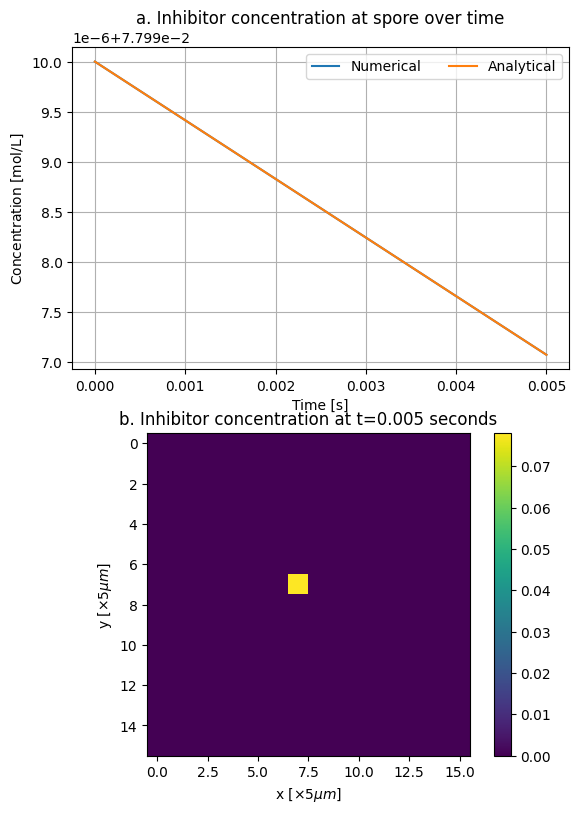

In [154]:
print(f"Thresholds reached at times: {times_thresh}")
print(f"Concentration dropped below {c_thresholds[-1]} at time {times_thresh[-1]}")

c_scale = 0.078
c_analytical_scaled = c_scale * c_analytical
c_evolution_scaled = c_scale * c_evolution
c_analytical_2_scaled = c_scale * c_analytical_2

# Compute threshold times analytically
# thresh_times_analytical = time_to_threshold_analytical(c_spore_init, D, spore_vol, 10.0**(-np.arange(1, 7)))

# Plot the concentration evolution
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
# axs[0].set_xlim(0,5)
axs[0].plot(times, c_evolution_scaled[:, spore_idx[0], spore_idx[1], spore_idx[2]], label='Numerical')
axs[0].plot(times, c_analytical_scaled, label='Analytical')
# axs[0].plot(times, c_analytical_2_scaled, label='Analytical 2')
for i, time_thresh in enumerate(times_thresh):
    dash_length = (i + 1)
    if time_thresh > 0:
        axs[0].axvline(x=time_thresh, color='c', dashes=(dash_length, dash_length), linewidth=2, label='$k=10^{'+str(-i-1)+'}$')
# for i, time_thresh in enumerate(thresh_times_analytical):
#     dash_length = (i + 1)
#     if time_thresh > 0:
#         axs[0].axvline(x=time_thresh, color='brown', dashes=(dash_length, dash_length), label='$k=10^{'+str(-i-1)+'}$ (analytical)')
# axs[0].set_ylim(0, c_scale+0.01)
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel(r'Concentration $[\text{mol}/\text{L}]$')
axs[0].set_title('a. Inhibitor concentration at spore over time')
axs[0].legend(loc='upper right', ncol=2)
axs[0].grid()
fig.tight_layout()

# Plot final concentrations on lattice
img = axs[1].imshow(c_evolution_scaled[-1, :, :, spore_idx[2]], cmap='viridis')
axs[1].set_xlabel(f'x [$\\times 5\\mu m$]')
axs[1].set_ylabel(f'y [$\\times 5\\mu m$]')
axs[1].set_title(f'b. Inhibitor concentration at t={t_max} seconds')
fig.colorbar(img, ax=axs[1])